# <span style="color:darkblue">Single Model Input Uncertainties using Stochastic Data Centering</span>

### <span style="color:black">A Quick Demo</span>



`Jay Thiagarajan`, `Rushil Anirudh`, `Vivek Narayanaswamy`, `Yamen Mubarka`, `Timo Bremer`      

# <span style="color:darkblue">Characterizing the Reliability of Predictions is Essential for Safely Deploying Models</span>


### What are epistemic uncertainties?
+ Given finite training data, many models can fit the same data well.
+ Variability in the hypotheses can be interpreted as model uncertainties.
+ “Reducible” and vanishes in the limit of infinite data.

<img style="display: block; margin-left: auto; margin-right: auto; width: 80%;" src="files/gp.png" alt="gp">

# <span style="color:darkblue">Existing Approaches for Quantifying Epistemic Uncertainties</span>

<img style="display: block; margin-left: auto; margin-right: auto; width: 100%;" src="files/uq.png" alt="UQ">

# <span style="color:darkblue">A Simple Thought Experiment</span>

Consider a training dataset $\mathcal{D} = {(x_i, y_i)}$

Now, construct biased datasets via centering and fit deep models to each of them

<img style="display: block; margin-left: auto; margin-right: auto; width: 80%;" src="files/expt.png" alt="expt">

# <span style="color:darkblue">Anchoring: A New Principle for Quantifying Epistemic Uncertainties</span>

### Looking at the effect of data centering through the lens of NTK
+ If we use a shift-invariant kernel to build models, we will learn the same function
+ <span style="color:orange">Interesting observation:</span> The neural tangent kernel induced by a deep network is not shift-invariant.

<img style="display: block; margin-left: auto; margin-right: auto; width: 100%;" src="files/ntk.png" alt="NTK">

# <span style="color:darkblue">Defining the anchoring process</span>

In the case of images, this can be implemented as channel concatenation

<img style="display: block; margin-left: auto; margin-right: auto; width: 100%;" src="files/anchor.png" alt="anchor">

# <span style="color:darkblue">A simple regression example</span>

In [2]:
import numpy as np
import sys
sys.path.insert(0,'..')

from lib.functions import *
from lib.modeldefs import MLP
from torch.optim import Adam, SGD
import torch
import random




seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = 'cpu'

In [3]:
indim = 1 # Number of input dimensions
outdim = 1 # # Number of output dimensions

# Create a test function
xs, ys, x_fine, y_fine = testfun(32)
xs -= 1.0
x_fine -= 1.0
n_samp = len(xs)

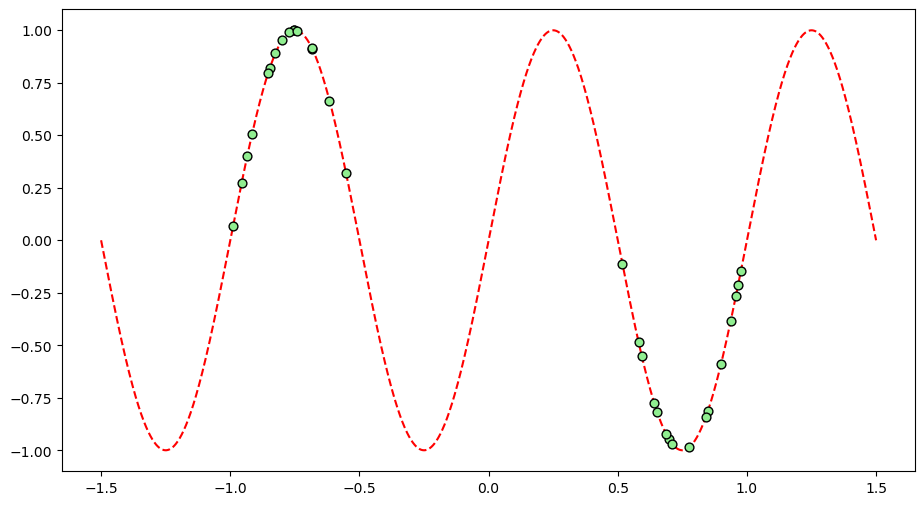

In [4]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(x_fine, y_fine,  color="r",linestyle='--',zorder=10, label='True Function')
ax.scatter(xs, ys, s=40, marker='o', label='Training Samples',edgecolor='k',c='lightgreen', zorder=30)
plt.show()

# <span style="color:darkblue">Model Creation - A Simple MLP for Anchored Prediction</span>

In [5]:
from lib.deltaUQ import deltaUQ

#modify the base class to create your own forward function

class uq_wrapper(deltaUQ):
    def forward(self,x,anchors=None,n_anchors=1,return_std=False):

        if n_anchors==1 and return_std:
            raise Warning('Use n_anchor>1, std. dev cannot be computed!')

        a_batch = self.create_anchored_batch(x,anchors=anchors,n_anchors=n_anchors)
        p = self.net(a_batch)
        
        p = p.reshape(n_anchors,x.shape[0],p.shape[1])
        mu = p.mean(0)

        if return_std:
            std = p.std(0)
            return mu, std
        else:
            return mu

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

ys_t = torch.from_numpy(ys).view(-1,1).float() # convert numpy to torch variable

config = {}
config['activation'] = 'relu'
config['hidden_dim'] = 128
config['n_layers'] = 3

net = uq_wrapper(MLP(indim, outdim, 'cpu',bn=True,config=config)) # A 3-layer MLP
net.train()
opt = Adam(net.parameters(), lr = 2e-4)
h = torch.from_numpy(xs).view(-1,1).float()
h_fine = torch.from_numpy(x_fine).view(-1,1).float()


# <span style="color:darkblue">Training</span>

In [6]:
import torch.nn.functional as F

loss_fn = torch.nn.MSELoss()
n_epochs = 10000
make_anchors = lambda h: h.min()+torch.rand(1000,1)*(h.max()-h.min())
anchors = make_anchors(h)
for epoch in range(n_epochs):
    yhat = net(h,anchors=h)
    opt.zero_grad()
    
    f_loss = loss_fn(yhat, ys_t) 

    loss = f_loss
    loss.backward()
    opt.step()    
    if (epoch+1)%1000 == 0:
        print(f'Finished {epoch+1:5d}/{n_epochs} (loss: {f_loss.item():.3e})')


Finished  1000/10000 (loss: 4.602e-03)
Finished  2000/10000 (loss: 1.841e-03)
Finished  3000/10000 (loss: 7.543e-04)
Finished  4000/10000 (loss: 5.963e-04)
Finished  5000/10000 (loss: 6.570e-04)
Finished  6000/10000 (loss: 2.249e-03)
Finished  7000/10000 (loss: 8.834e-04)
Finished  8000/10000 (loss: 4.599e-04)
Finished  9000/10000 (loss: 3.247e-04)
Finished 10000/10000 (loss: 4.851e-04)


# <span style="color:darkblue"> Get predictions and uncertainties</span>

In [7]:
net.eval()
with torch.no_grad():
    y_mean, y_std = net(h_fine,anchors=h,n_anchors=30,return_std=True)
y_mean, y_std = y_mean.numpy().ravel(), y_std.numpy().ravel()

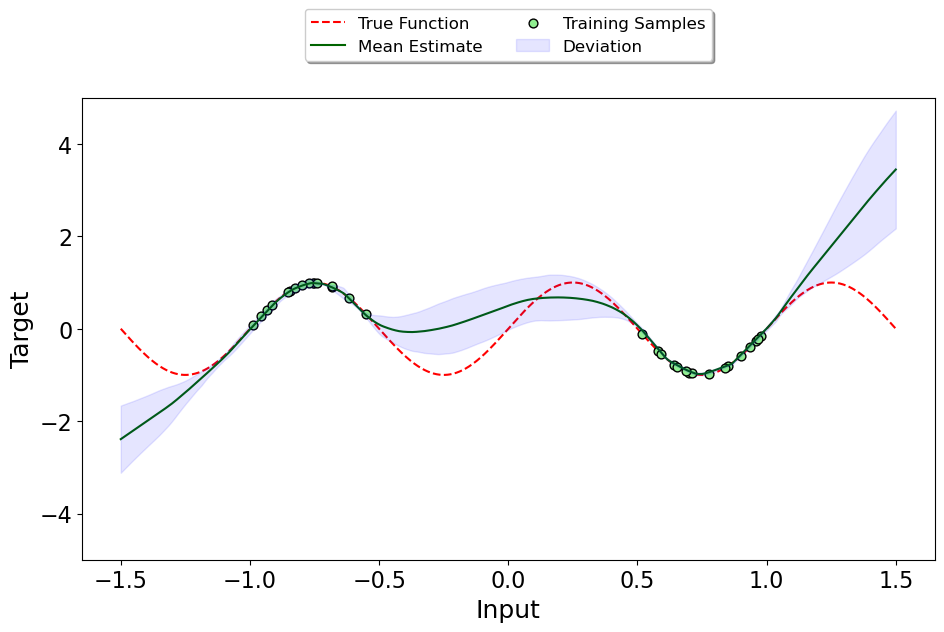

In [8]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(x_fine, y_fine,  color="r",linestyle='--',zorder=10, label='True Function')
ax.scatter(xs, ys, s=40, marker='o', label='Training Samples',edgecolor='k',c='lightgreen', zorder=30)

ax.plot(x_fine, y_mean,color = 'darkgreen',zorder=300,label='Mean Estimate')
ax.fill_between(x_fine, y_mean + 2*y_std, y_mean - 2*y_std, alpha=0.1,color='blue', zorder=400,label='Deviation')

plt.legend(fontsize=12, loc='upper center', ncol=2, bbox_to_anchor=(0.5,1.21), fancybox=True,shadow=True)
plt.xlabel('Input', fontsize = 18); plt.ylabel('Target', fontsize = 18)
plt.xticks(fontsize = 16); plt.yticks(fontsize = 16)
plt.ylim([-5,5])
plt.show()

# <span style="color:darkblue">Using $\Delta$-UQ Uncertainties in Active Learning</span>

<img style="display: block; margin-left: auto; margin-right: auto; width: 100%;" src="files/opt.png" alt="opt">

## <span style="color:darkblue">Find the Maximum of an 1D Function</span>

In [9]:
from lib.functions import functions,\
                bounds as boundsx, gopt as gopt
import lib.optdefs as op
import lib.utils as utils
function = 'multi_optima'
indim = 1
outdim = 1
n_init = 5
n_steps = 25
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


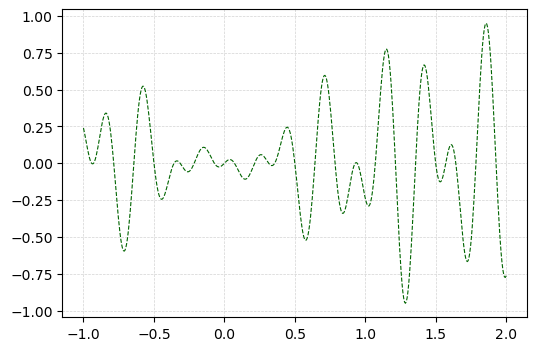

In [10]:
# Create test function

fct = functions[function]
b = boundsx[function]
global_opt = gopt[function]
f = lambda x: fct(x)

utils.plot2d(f,b)


## <span style="color:darkblue">Bayesian Optimization with Expected Improvement Acquisition</span>

<img style="display: block; margin-left: auto; margin-right: auto; width: 50%;" src="files/EI.png" alt="EI">

In [11]:
X_init = (b[1] - b[0]) * torch.rand(n_init, indim) + b[0]   
Y_init = f(X_init)
print('Max value in the Initial set:', torch.max(Y_init))
max_value_per_step, buffer = op.optimize(f, b, indim, outdim, X_init, Y_init, n_steps, scale=2**-8, drp = -1)

Max value in the Initial set: tensor(-0.0173)
Finished Step 5/25: Best value so far = 0.24460728466510773
Finished Step 10/25: Best value so far = 0.48210108280181885
Finished Step 15/25: Best value so far = 0.7707529664039612
Finished Step 20/25: Best value so far = 0.7707529664039612
Finished Step 25/25: Best value so far = 0.7707529664039612


## <span style="color:darkblue"> Convergence Behavior</span>

In [12]:
#AUC metric
from sklearn.metrics import auc
ymin, ymax = np.max(Y_init.data.numpy()), global_opt
curve = (np.array(max_value_per_step) - ymin)/(ymax - ymin)
xmin, xmax = n_init, n_init + n_steps + 1
samples = (np.arange(xmin, xmax) - xmin)/(xmax-xmin)
auc_metric = np.around(auc(samples, curve),3)

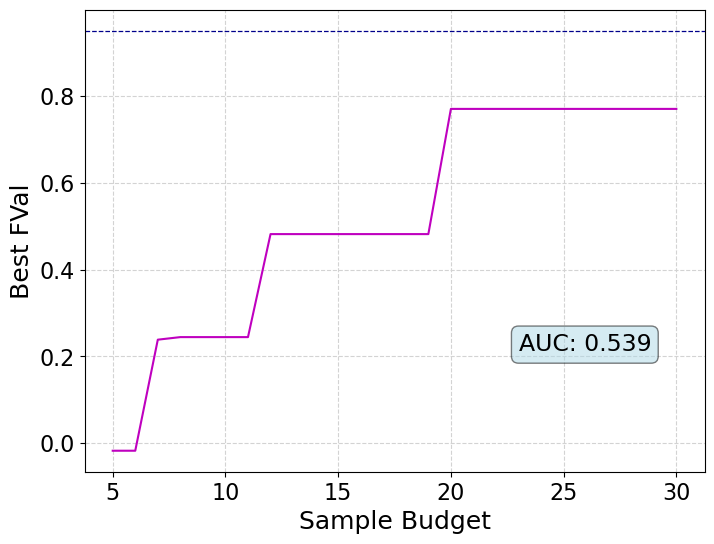

In [13]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(np.arange(n_init, n_init+n_steps+1), max_value_per_step, linewidth = 1.5, c = 'm')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.axhline(global_opt, c = 'darkblue', linestyle = '--',linewidth=0.9)
plt.grid(color = 'lightgray', linestyle = '--')
plt.xlabel('Sample Budget', fontsize = 18)
plt.ylabel('Best FVal', fontsize = 18)
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
ax.text(0.7, 0.3, f'AUC: {auc_metric}', transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)

plt.show()

# <span style="color:darkblue">A 2D Example</span>

In [14]:
from lib.functions import functions as fcn,\
                bounds as boundsx, gopt as gopt
function = 'ackley'
indim = 2
outdim = 1
n_init = 10
n_steps = 25
seed = 7
torch.manual_seed(seed)


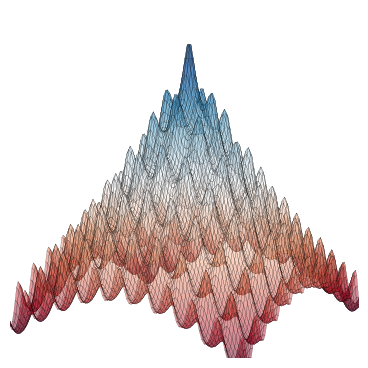

In [15]:
# Create test function
import lib.utils as utils
fct = functions[function]
b = boundsx[function]
global_opt = gopt[function]
f = lambda x: fct(x)

utils.plot3d(f,b)


## <span style="color:darkblue">Running Sequential Optimization</span>

In [16]:
X_init = (b[1] - b[0]) * torch.rand(n_init, indim) + b[0]   
Y_init = f(X_init)
print('Max value in the Initial set:', torch.max(Y_init))
max_value_per_step, buffer = op.optimize(f, b, indim, outdim, X_init, Y_init, n_steps, scale = 2**-7, drp = -1)


Max value in the Initial set: tensor(-6.1559)
Finished Step 5/25: Best value so far = -3.006180763244629
Finished Step 10/25: Best value so far = -3.006180763244629
Finished Step 15/25: Best value so far = -3.006180763244629
Finished Step 20/25: Best value so far = -2.446810722351074
Finished Step 25/25: Best value so far = -2.446810722351074


## <span style="color:darkblue">Convergence Behavior</span>

In [17]:
#AUC metric
from sklearn.metrics import auc
ymin, ymax = np.max(Y_init.data.numpy()), global_opt
curve = (np.array(max_value_per_step) - ymin)/(ymax - ymin)
xmin, xmax = n_init, n_init + n_steps + 1
samples = (np.arange(xmin, xmax) - xmin)/(xmax-xmin)
auc_metric = np.around(auc(samples, curve),3)

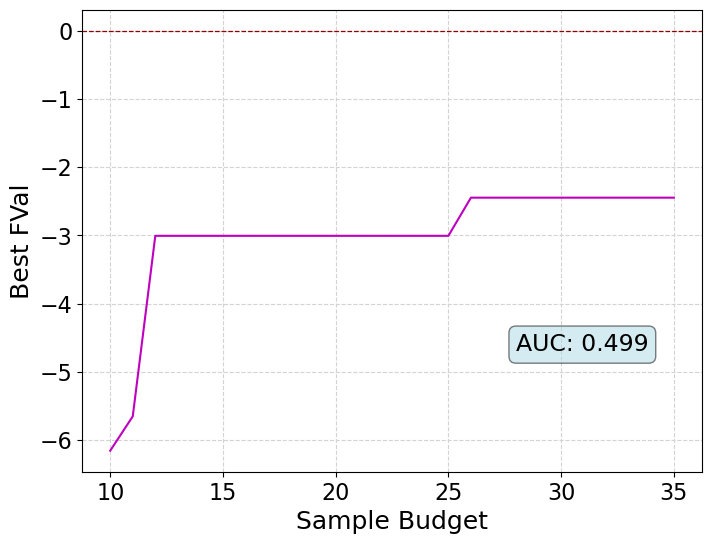

In [18]:
fig,ax = plt.subplots(figsize = (8,6))
plt.plot(np.arange(n_init, n_init+n_steps+1), max_value_per_step, linewidth = 1.5, c = 'm')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.axhline(global_opt, c = 'darkred', linestyle = '--',linewidth=0.9)
plt.grid(color = 'lightgray', linestyle = '--')
plt.xlabel('Sample Budget', fontsize = 18)
plt.ylabel('Best FVal', fontsize = 18)
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
ax.text(0.7, 0.3, f'AUC: {auc_metric}', transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)
plt.show()

# <span style="color:darkblue">Optimizing in a GAN's Latent Space</span>

<img style="display: block; margin-left: auto; margin-right: auto; width: 50%;" src="files/gan.png" alt="gan">

In [19]:
from lib.dcgan import Generator

def GAN_fun(z, return_img = False):
    device = 'cpu'
    G = Generator(ngpu=0).to(device).eval()
    G.load_state_dict(torch.load('./files/netG_epoch_99.pth',map_location=device))
    z = z.view((-1,z.shape[1],1,1)).to(device)
    image = G(z).detach().cpu().numpy().reshape(z.shape[0], 28,28)
    image = (image + 1.)/(1. + 1.)
    thickness = np.sum(image>0.5, axis=(1,2))
    if return_img:
        return torch.from_numpy(thickness).float(), image
    else:
        return torch.from_numpy(thickness).float()

## <span style="color:darkblue">Running the Optimization Loop</span>

In [ ]:
indim = 100
outdim = 1
n_init = 50 
n_steps = 20
f = lambda x: GAN_fun(x)
torch.manual_seed(14)
b = [-2, 2]

X_init = (b[1] - b[0]) * torch.rand(n_init, indim) + b[0]   
Y_init = f(X_init)
print('Max value in the Initial set:', torch.max(Y_init))
max_value_per_step, buffer = op.optimize(f, b, \
 indim, outdim, X_init, Y_init, n_steps, scale = 2**-9, drp = 0.3)


Max value in the Initial set: tensor(188.)
Finished Step 5/20: Best value so far = 188.0


(-0.5, 27.5, 27.5, -0.5)

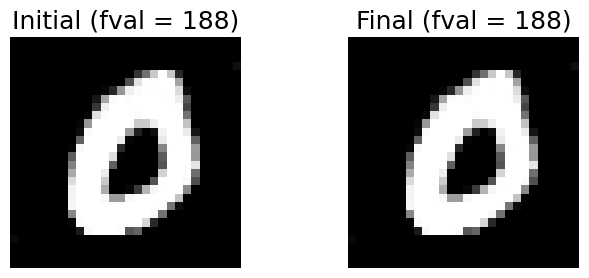

In [22]:
fig, ax = plt.subplots(1,2,figsize = (8,3))
idx = np.argmax(Y_init.detach().numpy())
z = X_init[idx].view(1,100)
fval, img = GAN_fun(z, return_img=True)
ax[0].imshow(img[0], cmap = 'gray')
ax[0].set_title(f'Initial (fval = {fval[0].int()})',fontsize=18)
ax[0].axis('off')

idx = np.argmax(buffer[1])
z = buffer[0][idx].view(1,100)
fval, img = GAN_fun(z, return_img=True)
ax[1].imshow(img[0], cmap = 'gray')
ax[1].set_title(f'Final (fval = {fval[0].int()})',fontsize=18)
ax[1].axis('off')


# <span style="color:darkblue">Resources</span>

+ Single Model Uncertainty Estimation via Stochastic Data Centering, NeurIPS 2022. <a href="https://neurips.cc/virtual/2022/poster/53044"> `paper` </a>, <a href="https://github.com"> `codes` </a> 

+ Out of Distribution Detection via Neural Network Anchoring, ACML 2022. <a href="https://arxiv.org/abs/2207.04125"> `paper` </a>, <a href="https://github.com/LLNL/AMP"> `codes` </a>

+ Data-Efficient Scientific Design Optimization with Neural Network Surrogates, ICML 2022 ReALML Workshop. <a href="https://realworldml.github.io/files/cr/paper29.pdf"> `paper` </a>

+ Predicting the Generalization Gap in Deep Models using Anchoring, ICASSP 2022. <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9747136&casa_token=oQD_kBdM3VMAAAAA:bocWSkaT0q1WJZ-VP0_SSVhMOKSrnAy-dRYkN3yD9bfVEMv9PqcvihyjTvm56NLiYzWOMsap1Q&tag=1"> `paper` </a>
